In [1]:
from sys import path
from os.path import relpath, realpath, abspath, join, exists
from itertools import product, chain

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

pd.set_option('display.max_rows', 999)

In [2]:
from torchnetjson.builder import build_net

In [3]:
from thesis_v2 import dir_dict
from thesis_v2.data import load_data_helper
from thesis_v2.training.training_aux import load_training_results
from thesis_v2.training_extra.misc import count_params
from thesis_v2.models.maskcnn_polished_with_local_pcn.builder import load_modules

load_modules()

In [4]:
# folder_to_check = 'scripts/training/yuanyuan_8k_a_3day/maskcnn_polished_with_local_pcn'
# path.insert(0, join(dir_dict['root'], folder_to_check))
from thesis_v2.configs.model.maskcnn_polished_with_local_pcn import (
    explored_models_summer_2019_certain as param_iterator_obj,
    explored_models_summer_2019_certain_20200501 as param_iterator_obj_0501,
    keygen
)

In [5]:
# compute ccmax
from strflab.stats import cc_max
from thesis_v2.data.prepared.yuanyuan_8k import get_neural_data_per_trial

cc_max_all_neurons = cc_max(get_neural_data_per_trial(
    ('042318', '043018','051018',))
                           )
assert cc_max_all_neurons.shape == (79,)

In [6]:
def load_everything():
    _df_collect = []
    for idx, param in enumerate(chain(param_iterator_obj().generate(), param_iterator_obj_0501().generate())):
        if idx % 50 == 0:
            print(idx)
            
#         print(len(param))
        if param['input_size'] == 100:
            continue
        if len(param) == 23:
            param['train_keep'] = None
        
        assert len(param) == 24
        assert param['split_seed'] == 'legacy'
        assert param['out_channel'] == 16
        assert param['num_layer'] == 2
        assert param['kernel_size_l1'] == 9
        assert param['pooling_ksize'] == 3
        assert param['pooling_type'] == 'avg'
        
#         assert param['model_seed'] == 0
        
        key = keygen(**{k: v for k, v in param.items() if k not in {'scale', 'smoothness'}})
        # 10 to go.
        result = load_training_results(key, return_model=False)
        # load twice, first time to get the model.
        result = load_training_results(key, return_model=True, model=build_net(result['config_extra']['model']))
        num_epochs = [len(x) for x in result['stats_all']]
        
        cc_raw = np.asarray(result['stats_best']['stats']['test']['corr'])
        assert cc_raw.shape == (79,)
        
        if param['train_keep'] is None:
            param['train_keep'] = 5120
            
        
        _df_collect.append(
            {
#                 'split_seed': str(param['split_seed']),
                
                'train_keep': param['train_keep'],
                'act_fn': param['act_fn'],
                'bn_before_act': param['bn_before_act'],
                'bn_after_fc': param['bn_after_fc'],
                'input_size': param['input_size'],
                'loss_type': param['loss_type'],
                
                # 12 to go
                
                'scale': float(param['scale']),
                # 
                'smoothness': float(param['smoothness']),
                # 
                
                # 8 to go
                'pcn_bn': param['pcn_bn'],
                'pcn_bn_post': param['pcn_bn_post'],
                'pcn_bypass': param['pcn_bypass'],
                'pcn_final_act': param['pcn_final_act'],
                'pcn_no_act': param['pcn_no_act'],
                'pcn_bias': param['pcn_bias'],
                
                'pcn_cls': param['pcn_cls'],
                
                'model_seed': param['model_seed'],
                
#                 'corr_test': result['stats_best']['stats']['test']['corr_mean'],
                'corr_test': ((cc_raw/cc_max_all_neurons)**2).mean(),
                'max_epoch': max(num_epochs),
                'num_param': count_params(result['model']),
            }
        )
    _df =  pd.DataFrame(_df_collect, columns=[
#             'split_seed',
        'train_keep',
        'act_fn', 'bn_before_act', 'bn_after_fc',
        'input_size', 'loss_type', 'scale',
        'smoothness',

        'pcn_bn', 'pcn_bn_post', 'pcn_bypass', 'pcn_final_act', 'pcn_no_act', 'pcn_bias', 'pcn_cls',
        'model_seed',

        'corr_test', 'num_param',
        'max_epoch',

                                             ])
    _df = _df.set_index([
        'train_keep',
        'act_fn', 'bn_before_act', 'bn_after_fc',
        'input_size', 'loss_type', 'scale',
        'smoothness',
        'pcn_bn', 'pcn_bn_post', 'pcn_bypass', 'pcn_final_act', 'pcn_no_act', 'pcn_bias', 'pcn_cls',
        'model_seed',
    ],verify_integrity=True)
    return _df

In [7]:
df = load_everything()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050


In [8]:
# mean and std here skip NAs.
corr_mean = df['corr_test'].unstack('model_seed').mean(axis=1)
num_param = df['num_param'].unstack('model_seed').mean(axis=1)
# corr_std = df['corr_test'].unstack('model_seed').std(axis=1)

In [9]:
corr_mean.xs(5120, level='train_keep').shape, corr_mean.xs(2560, level='train_keep').shape, corr_mean.xs(1280, level='train_keep').shape

((384,), (384,), (384,))

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

def scatter(x, y, xlabel, ylabel, title):
    
    # only check high performing cases.
    selector = np.logical_and(x>=0.5, y>=0.5)
    x=x[selector]
    y=y[selector]
    
    plt.close('all')
    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, s=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.xlim(0.4,0.8)
    plt.ylim(0.4,0.8)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.title(title)
    plt.show()
    print('y-x mean', (y-x).mean(), 'y-x>0 mean', ((y-x)>0).mean())
    print('y top', y.max(), 'x top', x.max())

(64, 6)
[0, 1, 2, 3, 4, 5]
1 - 0 mean 0.012732316451585773 sem 0.0031207625646854126
2 - 1 mean 0.002657213157902524 sem 0.0013891223601803196
3 - 2 mean 0.0022718426002932253 sem 0.001212607538141555
5 - 3 mean 0.0036053809357507313 sem 0.0012400787039248443
5 - 2 mean 0.005877223536043957 sem 0.001361524197182088


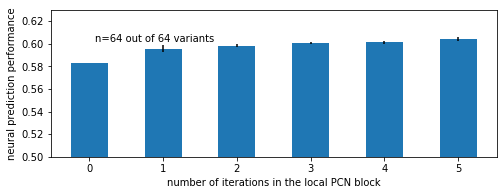

[0.5829852199092582, 0.595717536360844, 0.5983747495187465, 0.6006465921190398, 0.6013577318082836, 0.6042519730547904] [2.18398615 0.44605253 0.37966886 0.11839569 0.48128445]


,num_of_cycles,performance,gain %
0,0,0.582985,NaN
1,1,0.595718,2.183986
2,2,0.598375,0.446053
3,3,0.600647,0.379669
4,4,0.601358,0.118396
5,5,0.604252,0.481284


In [11]:
def plot_step_increase(data_this, pairs_to_check, ylim):
    # remove those no innner act ones.
    df_unstacked = data_this.unstack('pcn_cls')
#     df_unstacked = corr_mean.unstack('pcn_cls')
    print(df_unstacked.shape)
    
#     selector = df_unstacked.values[:,0] >= 0.50
    selector = ()
#     print(selector.mean())
    
    cls_values = df_unstacked.columns.values.tolist()
    print(cls_values)
    assert cls_values == list(range(len(cls_values)))
    
#     n = selector.sum()
#     print('n', n)
    n = df_unstacked.shape[0]
    
    for p1, p2 in pairs_to_check:
        val0 = df_unstacked.values[:,p1][selector]
        val1 = df_unstacked.values[:,p2][selector]

        # selection
        
        print(
            f'{p2} - {p1}',
            'mean', (val1-val0).mean(),
            'sem', (val1-val0).std()/np.sqrt(n)
        )
        
    # time to plot.
    # show results for cls_values[0] through cls_values[-1]
    # for the first one, just show mean,
    # for others show mean and s.e.m. of increase.
    
    mean_performance = []
    sem_increase = []
    labels = []
    
    for idx, cls_name in enumerate(cls_values):
        assert idx == cls_name
        mean_performance.append(df_unstacked.values[:,idx][selector].mean())
        if idx == 0:
            sem_increase.append(0.0)
        else:
            sem_increase.append((df_unstacked.values[:,idx][selector]-df_unstacked.values[:,idx-1][selector]).std()/np.sqrt(n))
        labels.append(str(cls_name))
        
    
    plt.close('all')
    fig = plt.figure(figsize=(8,3))
    plt.bar(np.arange(len(cls_values)), mean_performance, 0.5, yerr=sem_increase)
    plt.ylabel('neural prediction performance')
    plt.ylim(*ylim)
    plt.xlabel('number of iterations in the local PCN block')
    plt.xticks(np.arange(len(cls_values)), labels)
    
    
    plt.text(0.1, 0.8,
             f'n={n} out of {df_unstacked.shape[0]} variants', verticalalignment='center', horizontalalignment='left',
             transform=plt.gca().transAxes
            )
    fig.subplots_adjust(bottom=0.2)
#     savefig(fig, 'yuanyuan_8k_a_3day/maskcnn_polished_with_local_pcn/basic_for_certain_configs/main_cc2normed.pdf')
    
    plt.show()
    
    print(mean_performance, np.diff(mean_performance)/mean_performance[:-1]*100)
    
    
    return pd.DataFrame(
        data = {
            'num_of_cycles': cls_values,
            'performance': mean_performance,
            'gain %': np.concatenate([np.asarray([np.nan]),  np.diff(mean_performance)/mean_performance[:-1]*100])
        },
        columns = ['num_of_cycles', 'performance', 'gain %']
    )
    
    
# trend for 0-1-2 is good. then bad.
plot_step_increase(corr_mean.xs(5120, level='train_keep'), [(0,1),(1,2),(2,3),(3,5),(2,5)],
                  ylim=(0.5,0.63)
                  )

(64, 6)
[0, 1, 2, 3, 4, 5]
1 - 0 mean 0.009083748816861362 sem 0.006819167275076978
2 - 1 mean -0.0008815428860356011 sem 0.005694806339536148
3 - 2 mean 0.006004370344117026 sem 0.0036453864119145346
5 - 3 mean 0.0015152149191381631 sem 0.004747903948621806
5 - 2 mean 0.007519585263255189 sem 0.00572332330607749


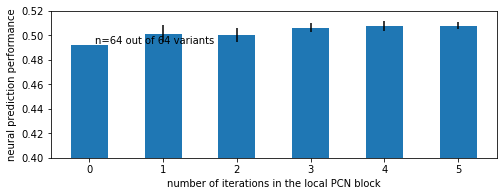

[0.49222980142785283, 0.5013135502447142, 0.5004320073586785, 0.5064363777027956, 0.5079121900551158, 0.5079515926219338] [ 1.84542845 -0.17584661  1.19983739  0.29141121  0.00775775]


,num_of_cycles,performance,gain %
0,0,0.492230,NaN
1,1,0.501314,1.845428
2,2,0.500432,-0.175847
3,3,0.506436,1.199837
4,4,0.507912,0.291411
5,5,0.507952,0.007758


In [12]:
plot_step_increase(corr_mean.xs(2560, level='train_keep'), [(0,1),(1,2),(2,3),(3,5),(2,5)],
                  ylim=(0.4,0.52)
                  )

(64, 6)
[0, 1, 2, 3, 4, 5]
1 - 0 mean 0.001612453786505822 sem 0.004925526618087092
2 - 1 mean 0.004904744680249838 sem 0.0027057062668152184
3 - 2 mean 0.00040219262083026155 sem 0.0018775553752708345
5 - 3 mean 0.0007811726026797344 sem 0.0020153101742649243
5 - 2 mean 0.0011833652235099957 sem 0.0022577078306945868


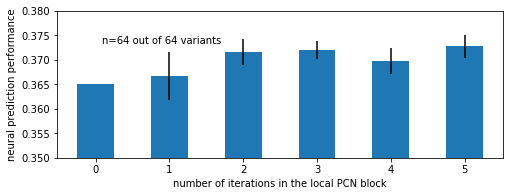

[0.36504608253885773, 0.3666585363253636, 0.3715632810056134, 0.37196547362644367, 0.3697482448691072, 0.3727466462291234] [ 0.44171239  1.3376873   0.10824337 -0.59608456  0.81093052]


,num_of_cycles,performance,gain %
0,0,0.365046,NaN
1,1,0.366659,0.441712
2,2,0.371563,1.337687
3,3,0.371965,0.108243
4,4,0.369748,-0.596085
5,5,0.372747,0.810931


In [13]:
plot_step_increase(corr_mean.xs(1280, level='train_keep'), [(0,1),(1,2),(2,3),(3,5),(2,5)],
                  ylim=(0.35,0.38)
                  )

training size 1280


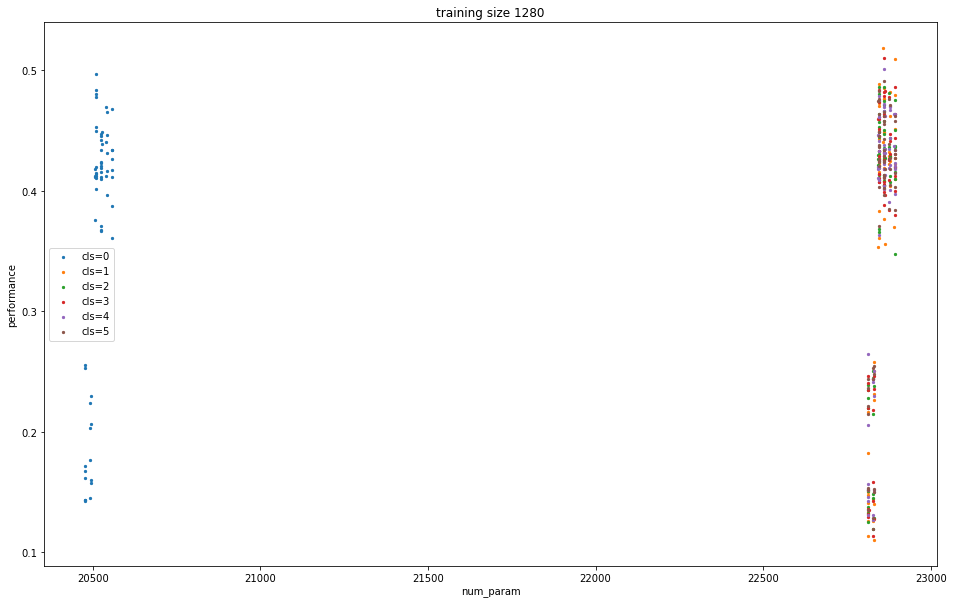

training size 2560


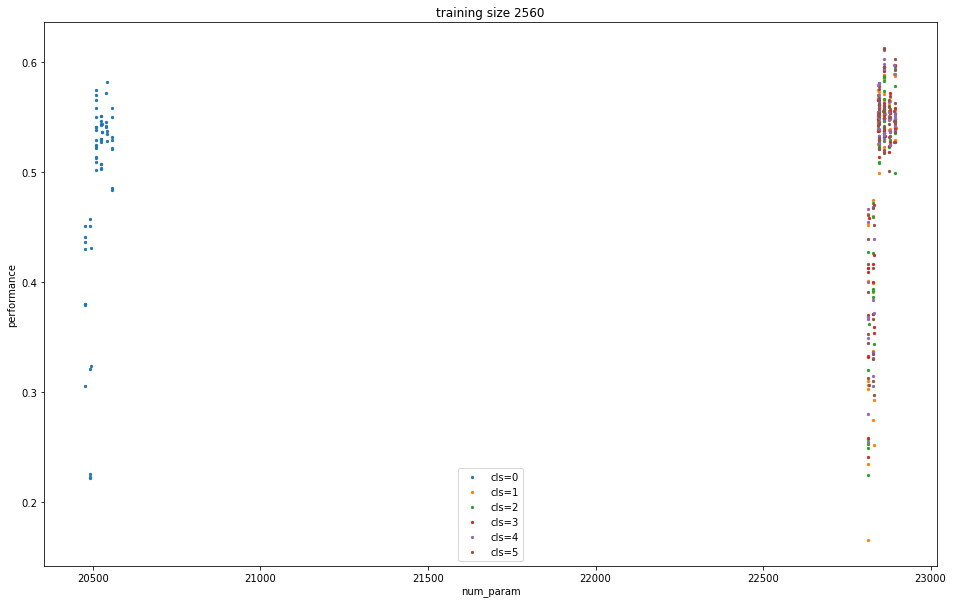

training size 5120


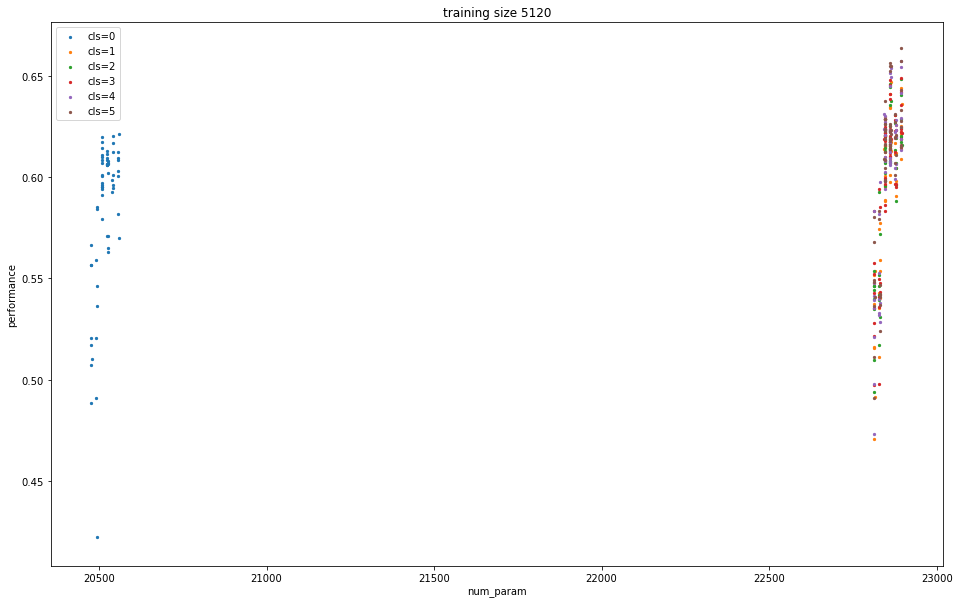

In [14]:
def check_relationship_between_num_param_and_perf_given_different_cycle():
    assert corr_mean.shape == num_param.shape
    assert corr_mean.index.equals(num_param.index)
    corr_mean_local = corr_mean.rename('corr_mean')
    num_param_local = num_param.rename('num_param')
    
    # combine them.
    df_to_check = pd.concat([corr_mean_local, num_param_local], axis=1)
    
    training_sizes = df_to_check.index.get_level_values('train_keep').unique()
    
    
    for training_size_this in training_sizes:
        print('training size', training_size_this)
        check_relationship_between_num_param_and_perf_given_different_cycle_inner(
            df_to_check.xs(training_size_this, level='train_keep'),
            title=f'training size {training_size_this}'
        )

def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(*arr.shape) * stdev
        
def check_relationship_between_num_param_and_perf_given_different_cycle_inner(df_to_check, title):
    cycle_list = df_to_check.index.get_level_values('pcn_cls').unique()
    
    plt.close('all')
    plt.figure(figsize=(16, 10))
    
    for c in cycle_list:
        data_this = df_to_check.xs(c, level='pcn_cls')
        plt.scatter(
            rand_jitter(data_this['num_param'].values),
            rand_jitter(data_this['corr_mean'].values),
            s=5,
            label=f'cls={c}',
        )
    
    plt.legend(loc='best')
#     plt.xlim(0,1)
#     plt.ylim(0,1)
#     plt.plot([0,1],[0,1],linestyle='--')
    plt.title(title)
    plt.xlabel('num_param')
    plt.ylabel('performance')
    
    
    plt.show()

check_relationship_between_num_param_and_perf_given_different_cycle()


# while I do not have a fairer comparison for cls=0 vs others with similar `num_param`,
# I think here the benefit of more cls is very limited or mixed, compared to
# https://github.com/leelabcnbc/thesis-yimeng-v2/blob/b37e51e3fda18c349f7bf34d715b7d90a7f31d2a/results_processed/yuanyuan_8k_a_3day/maskcnn_polished_with_rcnn_k_bl/basic_for_20200218ksize3%2B20200430_cc2normed.ipynb